<a href="https://colab.research.google.com/github/simnpeter/usernameApproving/blob/main/T5_lora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q bitsandbytes datasets accelerate
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git@main

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to bu

In [2]:
# Select CUDA device index
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, BitsAndBytesConfig

model_name = "google/flan-t5-large"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, quantization_config=BitsAndBytesConfig(load_in_8bit=True))
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [5]:
from google.colab import drive
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import DatasetDict, Dataset

drive.mount('/content/drive')

path='/content/drive/My Drive/Colab Notebooks/dataset.csv'

def custom_parser(line):
    parts = line.split(";")  # Felosztjuk a sort pontosvessző mentén
    # Az első elem az összes többi elem
    username = parts[0] if len(parts) == 1 else ";".join(parts[:-1])
    label = int(parts[-1])  # Utolsó elem a címke, ami számmá konvertálható
    return username, label

data = []
with open(path, "r") as file:
  for line in file:
        username, label = custom_parser(line.strip())
        data.append((username, label))

# Az adatok pandas DataFrame-be helyezése
df = pd.DataFrame(data, columns=["Username", "Label"])

df['Label'] = df['Label'].map({1: 'Approved', 0: 'Not approved'})

label_counts = df['Label'].value_counts()

grouped = df.groupby('Label')

balanced_df = grouped.apply(lambda x: x.sample(n=label_counts.min()))

balanced_df = balanced_df.reset_index(drop=True)

dataset_train, dataset_test = train_test_split(balanced_df, test_size=0.2, random_state=42)

dataset_train = Dataset.from_pandas(dataset_train)

dataset_test = Dataset.from_pandas(dataset_test)

dataset = DatasetDict({'train': dataset_train, 'test': dataset_test})

Mounted at /content/drive


In [6]:
len(balanced_df)

2598

In [7]:
from datasets import concatenate_datasets
import numpy as np

# The maximum total input sequence length after tokenization.
# Sequences longer than this will be truncated, sequences shorter will be padded.
tokenized_inputs = concatenate_datasets([dataset['train'], dataset['test']]).map(lambda x: tokenizer(x["Username"], truncation=True), batched=True, remove_columns=["Username", "Label"])
input_lenghts = [len(x) for x in tokenized_inputs["input_ids"]]
# take 85 percentile of max length for better utilization
max_source_length = int(np.percentile(input_lenghts, 85))
print(f"Max source length: {max_source_length}")

# The maximum total sequence length for target text after tokenization.
# Sequences longer than this will be truncated, sequences shorter will be padded."
tokenized_targets = concatenate_datasets([dataset['train'], dataset['test']]).map(lambda x: tokenizer(x["Label"], truncation=True), batched=True, remove_columns=["Username", "Label"])
target_lenghts = [len(x) for x in tokenized_targets["input_ids"]]
# take 90 percentile of max length for better utilization
max_target_length = int(np.percentile(target_lenghts, 90))
print(f"Max target length: {max_target_length}")

Map:   0%|          | 0/2598 [00:00<?, ? examples/s]

Max source length: 7


Map:   0%|          | 0/2598 [00:00<?, ? examples/s]

Max target length: 5


In [8]:
def preprocess_function(sample,padding="max_length"):
    # add prefix to the input for t5
    inputs = ["Is this username approvable: " + item for item in sample["Username"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=sample["Label"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=["Username", "Label", "__index_level_0__"])
print(f"Keys of tokenized dataset: {list(tokenized_dataset['train'].features)}")

# save datasets to disk for later easy loading
tokenized_dataset["train"].save_to_disk("data/train")
tokenized_dataset["test"].save_to_disk("data/eval")

Map:   0%|          | 0/2078 [00:00<?, ? examples/s]

Map:   0%|          | 0/520 [00:00<?, ? examples/s]

Keys of tokenized dataset: ['input_ids', 'attention_mask', 'labels']


Saving the dataset (0/1 shards):   0%|          | 0/2078 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/520 [00:00<?, ? examples/s]

In [9]:
from peft import prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

In [10]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=16, lora_alpha=32, target_modules=["q", "v"], lora_dropout=0.05, bias="none", task_type="SEQ_2_SEQ_LM"
)

model = get_peft_model(model, lora_config)

In [11]:
from transformers import TrainingArguments, Trainer

output_dir="/content/drive/My Drive/Colab Notebooks/lora-flan-t5-base"

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=1e-3,
    gradient_accumulation_steps=1,
    auto_find_batch_size=True,
    num_train_epochs=20,
    save_steps=100,
    save_total_limit=8,
    save_strategy="epoch",
    load_best_model_at_end =True
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)
model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch,Training Loss,Validation Loss
1,No log,0.175561
2,0.231900,0.178660
3,0.231900,0.174667
4,0.189100,0.177784
5,0.189100,0.176725
6,0.188800,0.184550
7,0.188800,0.177979
8,0.186300,0.181320
9,0.186300,0.174654
10,0.181100,0.175928


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is r

TrainOutput(global_step=5200, training_loss=0.18838258596567006, metrics={'train_runtime': 7016.0562, 'train_samples_per_second': 5.924, 'train_steps_per_second': 0.741, 'total_flos': 1317812748779520.0, 'train_loss': 0.18838258596567006, 'epoch': 20.0})

In [13]:
peft_model_id="/content/drive/My Drive/Colab Notebooks/results_june"
trainer.model.save_pretrained(peft_model_id)
tokenizer.save_pretrained(peft_model_id)

('/content/drive/My Drive/Colab Notebooks/results_june/tokenizer_config.json',
 '/content/drive/My Drive/Colab Notebooks/results_june/special_tokens_map.json',
 '/content/drive/My Drive/Colab Notebooks/results_june/spiece.model',
 '/content/drive/My Drive/Colab Notebooks/results_june/added_tokens.json',
 '/content/drive/My Drive/Colab Notebooks/results_june/tokenizer.json')

In [14]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Definiálj egy változót a mentett modell és tokenizer útvonalával
peft_model_id = "/content/drive/My Drive/Colab Notebooks/results_june"

# Töltsd be a modelled és a tokeneződet
model = T5ForConditionalGeneration.from_pretrained(peft_model_id)
tokenizer = T5Tokenizer.from_pretrained(peft_model_id)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
test = dataset['test']

df = test.to_pandas()

# Username oszlop módosítása
df['Username'] = ["Is this username approvable: " + username for username in df["Username"]]

# Módosított DataFrame visszaalakítása Dataset objektummá
test = Dataset.from_pandas(df)

In [26]:
from datasets import load_dataset
import torch

# Betöltés és előkészítés a tesztkészlettel való predikcióhoz
# Például "Username" vagy bármi egyéb bemeneti oszlop neve
inputs = test['Username']

# Predikció végrehajtása a tesztkészleten
predictions = []
for input_text in inputs:
    # Tokenizáció és inputok előkészítése
    inputs = tokenizer(input_text, return_tensors="pt")
    # Predikció végrehajtása
    outputs = model.generate(**inputs)
    # Decodolás
    answer = tokenizer.decode(outputs[0],skip_special_tokens=True)
    # A predikció hozzáadása a listához
    predictions.append(answer)

# A predikciók hozzáadása a tesztkészlethez
#test["predicted_labels"] = predictions
predictions_df = pd.DataFrame({"predicted_labels": predictions})

# Concatenate the predictions dataframe with your test dataset
test_df = test.to_pandas()

# Concatenate the predictions DataFrame with the test DataFrame
test_with_predictions = pd.concat([test_df, predictions_df], axis=1)
# Eredmények kiértékelése vagy mentése


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1202: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [23]:
input_text = "Is this username approvable: tfiswronh"

# Tokenizáció és inputok előkészítése
inputs = tokenizer(input_text, return_tensors="pt")
# Predikció végrehajtása
outputs = model.generate(**inputs)
# Decodolás
answer = tokenizer.decode(outputs[0],skip_special_tokens=True)
# A predikció hozzáadása a listához
print(answer)


Not approved


In [17]:
from sklearn.metrics import accuracy_score

# Előrejelzések és címkék kinyerése
predicted_labels = test_with_predictions["predicted_labels"]
true_labels = test_with_predictions["Label"]  # Címkék oszlopnév

# Pontosság kiszámítása
accuracy = accuracy_score(true_labels, predicted_labels)

# Pontosság kiírása
print(f"A modell pontossága: {accuracy * 100:.2f}%")

A modell pontossága: 48.46%


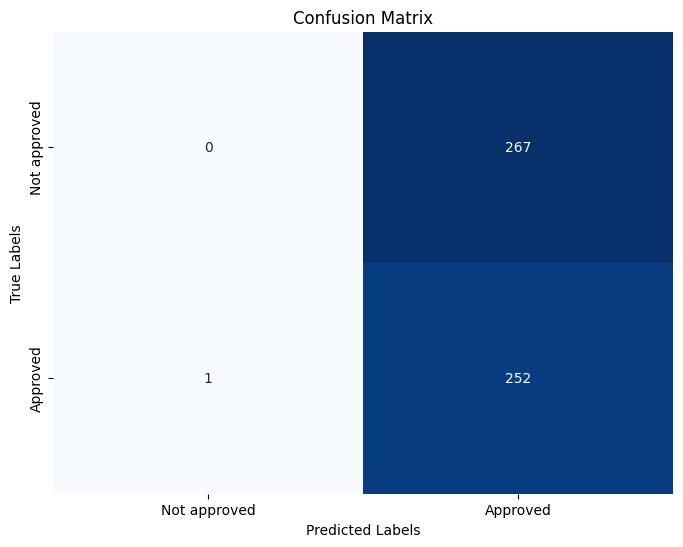

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['Not approved', 'Approved']

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()